In [0]:
import sys
import cv2
import numpy as np
from scipy.interpolate import interp1d
from PIL import Image
from skimage.color import rgb2gray
from google.colab.patches import cv2_imshow
import re
import cv2
import glob
import math
from scipy.spatial import distance
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
import matplotlib.pyplot as plt
import pandas as pd
from sklearn import metrics
import os
import glob

from google.colab import drive
drive.mount('/content/drive')

img_dir = "/content/drive/My Drive/Colab Notebooks/duhovky/duhovky" # Enter Directory of all images
iris_annotation = "/content/drive/My Drive/Colab Notebooks/duhovky/duhovky/iris_annotation.csv" 

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
!pip install opencv-python==3.4.2.16

In [0]:
annotationpath = "/content/drive/My Drive/Colab Notebooks/duhovky/duhovky/iris_annotation.csv"
predicted={}
with open(annotationpath, 'r') as f:
    lines = f.readlines()[1:]  

for line in lines:
    line = re.sub(' +', ',', line[:-1])
    predictedPole =line.split(",")
    #predictedPole[0] = predictedPole[0].split("/")[-1]
    predicted[predictedPole[0]] = list(map(int, predictedPole[1:]))

In [0]:
def processing(image,r):                                  
    #cv2_imshow(image)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    image = cv2.resize(image, (320, 280), interpolation=cv2.INTER_LINEAR)
    gray = cv2.medianBlur(image, 11)
    ret, _ = cv2.threshold(gray, 0, 142, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    circles = cv2.HoughCircles(gray, cv2.HOUGH_GRADIENT, 1, 50, param1=ret, param2=30, minRadius=20,
                               maxRadius=100)
    if (circles is None):
      return False,False
    circles = circles[0, :, :]  
    circles = np.int16(np.around(circles)) 
    
    for i in circles[:]:
      #cv2.circle(image, (i[0], i[1]), i[2], (0, 255, 0), thickness = 2)
      #cv2.circle(image, (i[0], i[1]), i[2]+r, (0, 0, 0), thickness = 2) 
      if ((i[1] - i[2] - r) < 0 or (i[1] + i[2] + r) >= 280 or (i[0] - i[2] -r) < 0 or (i[0] + i[2] + r) >= 320):
        return False, False
      image = image[i[1] - i[2] - r:i[1] + i[2] + r, i[0] - i[2] -r:i[0] + i[2] + r]
      radus = i[2]
    
    return image, radus 


def daugman_normalizaiton(image, height, width, r_in, r_out):       
    thetas = np.arange(0, 2 * np.pi, 2 * np.pi / width)  
    r_out = r_in + r_out
    flat = np.zeros((height,width, 3), np.uint8)
    circle_x = int(image.shape[0] / 2)
    circle_y = int(image.shape[1] / 2)

    for i in range(width):
        for j in range(height):
            theta = thetas[i]  
            r_pro = j / height  

            Xi = circle_x + r_in * np.cos(theta)
            Yi = circle_y + r_in * np.sin(theta)
            Xo = circle_x + r_out * np.cos(theta)
            Yo = circle_y + r_out * np.sin(theta)

            Xc = (1 - r_pro) * Xi + r_pro * Xo
            Yc = (1 - r_pro) * Yi + r_pro * Yo

            if(Xc >= image.shape[0]):
              Xc = image.shape[0] - 1
            if(Yc >= image.shape[1]):
              Yc = image.shape[0] - 1
            color = image[int(Xc)][int(Yc)]  

            flat[j][i] = color
    return flat  


In [0]:


def create_circular_mask(h, w, center=None, radius=None):

    if center is None: 
        center = (int(w/2), int(h/2))
    if radius is None: 
        radius = min(center[0], center[1], w-center[0], h-center[1])

    Y, X = np.ogrid[:h, :w]
    dist_from_center = np.sqrt((X - center[0])**2 + (Y-center[1])**2)

    mask = dist_from_center <= radius
    return mask

def DaugNormalization2(image,center_x,center_y,radius,hrubkaDuhovky,dolneviecko,horneviecko):
    img = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    hornecenter = (horneviecko[0],horneviecko[1])
    dolnecenter = (dolneviecko[0],dolneviecko[1])
    radiushorne =int(horneviecko[2])
    radiusdolne =int(dolneviecko[2])
    hornevieckomask = create_circular_mask(img.shape[0], img.shape[1],hornecenter,radiushorne)
    dolnevieckomask = create_circular_mask(img.shape[0], img.shape[1],dolnecenter,radiusdolne)
    masked_img = np.zeros((img.shape[0], img.shape[1], 1), np.uint8)
    masked_img.fill(255)
    masked_img[~hornevieckomask] = 0
    masked_img[~dolnevieckomask] = 0
    
    #cv2_imshow(masked_img)

    radius_pupil=int(radius)   
    samples = np.linspace(0,2*np.pi, 360)[:-1]
    polar = np.zeros((hrubkaDuhovky, 360))
    maskpolar = np.zeros((hrubkaDuhovky, 360))
    for r in range(hrubkaDuhovky):
        for theta in samples:
            x = (r+radius_pupil)*np.cos(theta)+center_x
            y = (r+radius_pupil)*np.sin(theta)+center_y
            x=int(x)
            y=int(y)
            try:
                polar[r][int((theta*360)/(2*np.pi))] = img[y][x]
                maskpolar[r][int((theta*360)/(2*np.pi))] = masked_img[y][x]
            except IndexError: 
                pass
            continue
    res = cv2.resize(polar,(512,64))
    resmask =cv2.resize(maskpolar,(512,64))
    return res,resmask

In [0]:
dfObj = pd.read_csv(annotationpath)


In [0]:
data = {}
img_dir = "/content/drive/My Drive/Colab Notebooks/duhovky/duhovky/" 
i=0

dataTruth = {}
dataHough = {}
maska = {}

for name in predicted.keys():
  i=i+1
  print(i)
  data_path = os.path.join(img_dir, name)
  name2 = data_path.split('/')[9].strip()
  if(os.path.isfile(data_path) == False):
    dfObj.drop( dfObj[ dfObj['image'] == name ].index , inplace=True)
    continue
  img = cv2.imread(data_path)
  data[name2] = img
  dolneviecko=[predicted[name][6],predicted[name][7],predicted[name][8]]
  horneviecko=[predicted[name][9],predicted[name][10],predicted[name][11]]

  
  image_nor,normmask =  DaugNormalization2(img, predicted[name][0],predicted[name][1],predicted[name][2],predicted[name][5]-predicted[name][2],dolneviecko,horneviecko)
  #cv2_imshow(image_nor)
  #cv2_imshow(normmask)

  image_roi, round = processing(data[name2],predicted[name][5]-predicted[name][2])
  if(image_roi is False or round is False):
    dfObj.drop( dfObj[ dfObj['image'] == name ].index , inplace=True)
    continue
  #cv2_imshow(image_roi)

  image_hog_nor =  daugman_normalizaiton(image_roi,60, 360, round, predicted[name][5]-predicted[name][2])
  #cv2_imshow(image_hog_nor)

  dataTruth[name2] = image_nor
  dataHough[name2] = image_hog_nor
  maska[name2] = normmask

  makedirNumber = data_path.split('/')[7].strip() + '/'
  Daugiedir = os.path.join('/content/drive/My Drive/Colab Notebooks/duhovkyDaugman/',makedirNumber)
  Houghdir = os.path.join('/content/drive/My Drive/Colab Notebooks/duhovkyHough/',makedirNumber)
  if (os.path.isdir(Daugiedir) == False ):
    os.mkdir(Daugiedir)
  if (os.path.isdir(Houghdir) == False):
    os.mkdir(Houghdir)  
  cv2.imwrite(Daugiedir + name2,image_nor)
  cv2.imwrite(Daugiedir + "MASK" + name2 ,normmask)
  cv2.imwrite(Houghdir + name2,image_hog_nor)


In [0]:
for name in predicted.keys():
  i=i+1
  # if (i < 815):
  #   continue
  print(i)
  data_path = os.path.join(img_dir, name)
  name2 = data_path.split('/')[9].strip()
  if(os.path.isfile(data_path) == False):
    dfObj.drop( dfObj[ dfObj['image'] == name ].index , inplace=True)
    continue

In [0]:
import pickle 
with open('/content/drive/My Drive/Colab Notebooks/iris.pickle', 'wb') as file:
  pickle.dump(data, file)
with open('/content/drive/My Drive/Colab Notebooks/dataTruth.pickle', 'wb') as file:
  pickle.dump(dataTruth, file)
with open('/content/drive/My Drive/Colab Notebooks/dataHough.pickle', 'wb') as file:
  pickle.dump(dataHough, file)
with open('/content/drive/My Drive/Colab Notebooks/maska.pickle', 'wb') as file:
  pickle.dump(maska, file)

In [0]:
dfObj.to_csv(r'/content/drive/My Drive/Colab Notebooks/trueirisannotation.csv',index=False,header=True)



## *Nacitanie validnych obrazkov z datasetu a ich anotacie*


In [103]:
import sys
import cv2
import numpy as np
from scipy.interpolate import interp1d
from PIL import Image
from skimage.color import rgb2gray
from google.colab.patches import cv2_imshow
import re
import cv2
import glob
import math
from scipy.spatial import distance
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
import matplotlib.pyplot as plt
import pandas as pd
from sklearn import metrics
import os
import glob
import pickle
from google.colab import drive
import random

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
import pickle 
data = {}
dataTruth = {}
maska = {}
with open('/content/drive/My Drive/Colab Notebooks/iris.pickle', 'rb') as file:
  data = pickle.load(file)
with open('/content/drive/My Drive/Colab Notebooks/dataTruth.pickle', 'rb') as file:
  dataTruth = pickle.load( file)
with open('/content/drive/My Drive/Colab Notebooks/dataHough.pickle', 'rb') as file:
  dataHough = pickle.load( file)
# with open('/content/drive/My Drive/Colab Notebooks/maska.pickle', 'rb') as file:
#   maska = pickle.load( file)

In [0]:
dataTruth

In [0]:
dfObjNew = pd.read_csv('/content/drive/My Drive/Colab Notebooks/trueirisannotation.csv')

## **ZACHRANA** spustit v pripade ze si si oddrbala zasa dict masiek Selepova !!!!!

In [0]:
predicted

In [0]:
img_dir = "/content/drive/My Drive/Colab Notebooks/duhovkyDaugman/" 
annotationpath = "/content/drive/My Drive/Colab Notebooks/trueirisannotation.csv"
predicted={}
i=0
with open(annotationpath, 'r') as f:
    lines = f.readlines()[1:]  

for line in lines:
    line = re.sub(' +', ',', line[:-1])
    predictedPole =line.split(",")
    #predictedPole[0] = predictedPole[0].split("/")[-1]
    predicted[predictedPole[0]] = list(map(int, predictedPole[1:]))
maska={}
array=[]
for name in predicted.keys():
  i=i+1
  out = name.split('/')[0] + "/MASK" + name.split('/')[2]
  array.append(out)
  data_path = os.path.join(img_dir, out)
  name2 = out

  img = cv2.imread(data_path)
  print(data_path)
  maska[name2] = img

In [0]:
import pickle

with open('/content/drive/My Drive/Colab Notebooks/maska.pickle', 'wb') as file:
  pickle.dump(maska, file)

In [0]:
with open('/content/drive/My Drive/Colab Notebooks/maska.pickle', 'rb') as file:
  maska = pickle.load(file)

maska

In [0]:
with open("/content/drive/My Drive/Colab Notebooks/output.txt", "w") as txt_file:   # "w" prehodit podla toho co chcem "r"
    for line in array:
        txt_file.write(" ".join(line) + "\n")

(64, 512, 3)

In [78]:
#Equalizes the histogram of the image
def ImageEnhancement(image):
    image = image.astype(np.uint8)
    im=cv2.equalizeHist(image)
    return im
i=0
equalized={}
for name in dataTruth:
  maskanew = maska[array[i]]
  maskanew = cv2.cvtColor(maskanew, cv2.COLOR_BGR2GRAY)
  #blurred_mask = cv2.blur(maskanew,Size(maskanew.shape[0],maskanew.shape[1]))
  image = cv2.bitwise_and(dataTruth[name].astype(np.uint8), maskanew)
  equalized[name] = ImageEnhancement(image)
  i=i+1
  if(i>1420 and i < 1450):
    cv2_imshow(equalized[name])


with open('/content/drive/My Drive/Colab Notebooks/aplikovanamaska.pickle', 'wb') as file:
  pickle.dump(equalized, file)



NameError: ignored

In [0]:
import pickle
with open('/content/drive/My Drive/Colab Notebooks/aplikovanamaska.pickle', 'rb') as file:
  maskedimage = pickle.load( file)
# maskedimage

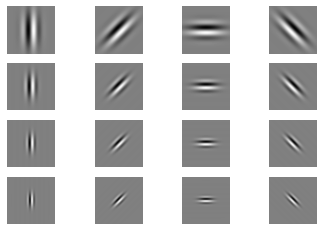

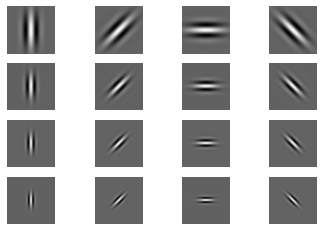

In [6]:
def genGabor(sz, omega, theta, func=np.cos, K=np.pi):
    radius = (int(sz[0]/2.0), int(sz[1]/2.0))
    [x, y] = np.meshgrid(range(-radius[0], radius[0]+1), range(-radius[1], radius[1]+1))

    x1 = x * np.cos(theta) + y * np.sin(theta)
    y1 = -x * np.sin(theta) + y * np.cos(theta)
    
    gauss = omega**2 / (4*np.pi * K**2) * np.exp(- omega**2 / (8*K**2) * ( 4 * x1**2 + y1**2))
#     myimshow(gauss)
    sinusoid = func(omega * x1) * np.exp(K**2 / 2)
#     myimshow(sinusoid)
    gabor = gauss * sinusoid
    return gabor
        
theta = np.arange(0, np.pi, np.pi/4) # range of theta
omega = np.arange(0.2, 0.6, 0.1) # range of omega
params = [(t,o) for o in omega for t in theta]
sinFilterBank = []
cosFilterBank = []
gaborParams = []
for (theta, omega) in params:
    gaborParam = {'omega':omega, 'theta':theta, 'sz':(128, 128)}
    sinGabor = genGabor(func=np.sin, **gaborParam)
    cosGabor = genGabor(func=np.cos, **gaborParam)
    sinFilterBank.append(sinGabor)
    cosFilterBank.append(cosGabor)
    gaborParams.append(gaborParam)

plt.figure()
plt.gray()
n = len(sinFilterBank)
for i in range(n):
    plt.subplot(4,4,i+1)
    # title(r'$\theta$={theta:.2f}$\omega$={omega}'.format(**gaborParams[i]))
    plt.axis('off'); plt.imshow(sinFilterBank[i])

plt.figure()
for i in range(n):
    plt.subplot(4,4,i+1)
    # title(r'$\theta$={theta:.2f}$\omega$={omega}'.format(**gaborParams[i]))
    plt.axis('off'); plt.imshow(cosFilterBank[i])

In [0]:
cv2_imshow(maskedimage['S1108L02.jpg'])

In [0]:
from skimage.color import rgb2gray
from scipy.signal import convolve2d
from skimage.filters import threshold_mean

i=0
customgabor={}
getgabor={}
customgaborbinary = {}
getgaborbinary = {}
for name in maskedimage.keys():
  if "L" in name :
    continue;
  # if i >= 20 :
  #   break;
  obr = maskedimage[name]

  g_kernel = cv2.getGaborKernel((15, 15), 6.0, 50, 8.0, 1, 90, ktype=cv2.CV_64F)
  g_kernel2 = cv2.getGaborKernel((15, 15), 5.0, 90, 8.0, 0.6, 10, ktype=cv2.CV_64F)
  g_kernel3 = cv2.getGaborKernel((15, 15), 6.0, 150, 8.0, 0.6, 80, ktype=cv2.CV_64F)
  #plt.figure(); plt.imshow(g_kernel)
  #plt.figure(); plt.imshow(g_kernel2)
  res = convolve2d(obr, sinFilterBank[1], mode='same') 
  res = convolve2d(obr, cosFilterBank[1], mode='same') 
  res = convolve2d(obr, cosFilterBank[9], mode='same') 
  res = convolve2d(obr, sinFilterBank[8], mode='same') 
  #test s cv2 kniznicou gaborovych filtrov
  novy = convolve2d(obr, g_kernel, mode='same') 
  novy = convolve2d(obr, g_kernel2, mode='same') 
  novy = convolve2d(obr, g_kernel3, mode='same') 

  thresh = threshold_mean(res)
  binary = res>thresh
  thresh2 = threshold_mean(novy)
  binary2 = novy>thresh2

  customgabor[name]=res
  getgabor[name]=novy
  customgaborbinary[name] = binary
  getgaborbinary[name] =binary2
  if (i < 200 and i > 180):
    
    #vykreslovanie
    f, axarr = plt.subplots(1,5,figsize=(25,25))

    axarr[0].set_title('Original ' + name)
    axarr[0].imshow(obr)

    axarr[1].set_title('GABOR NO.1')
    axarr[1].imshow(res,cmap=plt.cm.gray);

    axarr[2].set_title('GABOR NO.2')
    axarr[2].imshow(novy);

    axarr[3].set_title('Mean thresh bin. GABOR NO.1')
    axarr[3].imshow(binary)

    axarr[4].set_title('Mean thresh bin. GABOR NO.2')
    axarr[4].imshow(binary2)

  i=i+1

import pickle
with open('/content/drive/My Drive/Colab Notebooks/getgaborbinary.pickle', 'wb') as file:
  pickle.dump(getgaborbinary, file)
with open('/content/drive/My Drive/Colab Notebooks/customgaborbinary.pickle', 'wb') as file:
  pickle.dump(customgaborbinary, file)
with open('/content/drive/My Drive/Colab Notebooks/getgabor.pickle', 'wb') as file:
  pickle.dump(getgabor, file)
with open('/content/drive/My Drive/Colab Notebooks/customgabor.pickle', 'wb') as file:
  pickle.dump(customgabor, file)

In [0]:
import pickle
with open('/content/drive/My Drive/Colab Notebooks/getgabor.pickle', 'rb') as file:
  getgabor = pickle.load( file)
len(getgabor)

In [0]:
import pickle
with open('/content/drive/My Drive/Colab Notebooks/customgaborbinary.pickle', 'rb') as file:
  customgaborbinary = pickle.load( file)

In [121]:
import pickle
with open('/content/drive/My Drive/Colab Notebooks/getgaborbinary.pickle', 'rb') as file:
  getgaborbinary = pickle.load( file)
getgaborbinary['S1199R08.jpg'].shape

(64, 512)

## **LBF FEATURE EXTRAKCIA ALETERNATIVA KU GABOROVYM FILTROM**

In [0]:
from skimage.feature import local_binary_pattern
from scipy.stats import itemfreq
from sklearn.preprocessing import normalize

LBP_face_features={}
for name in maskedimage.keys():
  rgbimg = maskedimage[name]
  img = rgb2gray(rgbimg) 
  radius = 3
  no_points = 8 * radius
  lbp = local_binary_pattern(img, no_points, radius, method='uniform')
  x = itemfreq(lbp.ravel())
  hist = x[:, 1]/sum(x[:, 1])
  LBP_face_features[name] = hist
  print(lbp)

In [0]:
cv2_imshow(LBP_face_features['S1108L01.jpg'])

In [0]:
def findTrue(identity,numofphoto,dicttofind):
  rand = []
  for name in dicttofind.keys():
    if name.split("R")[0].replace("S1",'') == identity and   numofphoto != name.split("R")[1]:
      rand.append(name)
  if not rand:
    return None
  else:
    return random.choice(rand)   
       
def findImpostor(identity,numofphoto,dicttofind):
  rand = []
  for name in dicttofind.keys():
    if name.split("R")[0].replace("S1",'') != identity:
      rand.append(name)
  return random.choice(rand)      


truepair = []
impostor = []
for name in LBP_face_features.keys():
  if "L" in name :
    continue;
  identity = name.split("R")[0].replace("S1",'')
  numofphoto = name.split("R")[1]
  truematch= findTrue(identity,numofphoto,getgaborbinary)
  impostormatch = findImpostor(identity,numofphoto,LBP_face_features)
  if truematch is None:
    continue
  truepair.append((name,truematch))
  impostor.append((name,impostormatch))

[LibSVM]Accuracy: 0.7305122494432071


              precision    recall  f1-score   support

         0.0       0.85      0.60      0.70       238
         1.0       0.66      0.88      0.75       211

    accuracy                           0.73       449
   macro avg       0.75      0.74      0.73       449
weighted avg       0.76      0.73      0.73       449

Area under the ROC curve : 0.836214


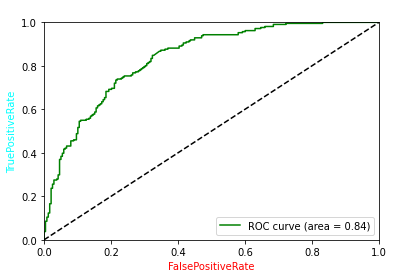

In [105]:
from sklearn import svm
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
random_state = np.random.RandomState(0)
from sklearn.metrics import roc_curve, auc
import pylab as pl
from sklearn.metrics import classification_report,accuracy_score

LBPtrueidentity = []
LBPfalseidentity = []
for pair in truepair:
  prvy = LBP_face_features.get(pair[0])
  druhy = LBP_face_features.get(pair[1])
  new_data = np.concatenate((prvy,druhy), axis=0)
  LBPtrueidentity.append(new_data)

for pair in impostor:
  prvy = LBP_face_features.get(pair[0])
  druhy = LBP_face_features.get(pair[1])
  new_data = np.concatenate((prvy,druhy), axis=0)
  LBPfalseidentity.append(new_data)

random_state = np.random.RandomState(0)

clf = svm.SVC(kernel='rbf', probability=True, verbose=1)
LBP_features = np.vstack((LBPtrueidentity, LBPfalseidentity)).astype(np.float64)
scaler = StandardScaler().fit(LBP_features)
x = scaler.transform(LBP_features)
y = np.hstack((np.ones(len(LBPtrueidentity)), np.zeros(len(LBPfalseidentity))))
x, y = shuffle(x, y, random_state=random_state)


# Training Features...
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2)
probas_ = clf.fit(x_train,y_train).predict_proba(x_test)
y_pred = clf.predict(x_test)
print("Accuracy: "+str(accuracy_score(y_test, y_pred)))
print('\n')
print(classification_report(y_test, y_pred))

# Compute ROC curve and area the curve
fpr, tpr, thresholds = roc_curve(y_test, probas_[:, 1])
roc_auc = auc(fpr, tpr)
print("Area under the ROC curve : %f" % roc_auc)

# Plot ROC curve
pl.clf()
pl.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc,color='green')
pl.plot([0, 1], [0, 1], 'k--')
pl.xlim([0.0, 1.0])
pl.ylim([0.0, 1.0])
pl.xlabel('FalsePositiveRate',color='red')
pl.ylabel('TruePositiveRate',color='aqua')
pl.title('ROC pre LBP príznaky',color='white')
pl.legend(loc="lower right")
pl.show()

## ***Hammingova vzdialenost***


> vzdialenost pixelov pri SVM musim spustit tu druhu cell tam sa obrazky dokopy spajaju





In [114]:
#GETGABORBINARY DATASET
def findTrue(identity,numofphoto,dicttofind):
  rand = []
  for name in dicttofind.keys():
    if name.split("R")[0].replace("S1",'') == identity and   numofphoto != name.split("R")[1]:
      rand.append(name)
  if not rand:
    return None
  else:
    return random.choice(rand)   
       
def findImpostor(identity,numofphoto,dicttofind):
  rand = []
  for name in dicttofind.keys():
    if name.split("R")[0].replace("S1",'') != identity:
      rand.append(name)
  return random.choice(rand)      


truepair = []
impostor = []
for name in getgaborbinary.keys():
  identity = name.split("R")[0].replace("S1",'')
  numofphoto = name.split("R")[1]
  truematch= findTrue(identity,numofphoto,getgaborbinary)
  impostormatch = findImpostor(identity,numofphoto,getgaborbinary)
  if truematch is None:
    continue
  truepair.append((name,truematch))
  impostor.append((name,impostormatch))

print(truepair)
print(impostor)

[('S1001R01.jpg', 'S1001R05.jpg'), ('S1001R02.jpg', 'S1001R01.jpg'), ('S1001R03.jpg', 'S1001R01.jpg'), ('S1001R04.jpg', 'S1001R03.jpg'), ('S1001R05.jpg', 'S1001R04.jpg'), ('S1001R06.jpg', 'S1001R10.jpg'), ('S1001R07.jpg', 'S1001R10.jpg'), ('S1001R08.jpg', 'S1001R09.jpg'), ('S1001R09.jpg', 'S1001R07.jpg'), ('S1001R10.jpg', 'S1001R06.jpg'), ('S1002R01.jpg', 'S1002R04.jpg'), ('S1002R03.jpg', 'S1002R07.jpg'), ('S1002R04.jpg', 'S1002R07.jpg'), ('S1002R07.jpg', 'S1002R04.jpg'), ('S1004R01.jpg', 'S1004R07.jpg'), ('S1004R02.jpg', 'S1004R03.jpg'), ('S1004R03.jpg', 'S1004R07.jpg'), ('S1004R04.jpg', 'S1004R03.jpg'), ('S1004R05.jpg', 'S1004R02.jpg'), ('S1004R06.jpg', 'S1004R03.jpg'), ('S1004R07.jpg', 'S1004R04.jpg'), ('S1005R02.jpg', 'S1005R07.jpg'), ('S1005R06.jpg', 'S1005R07.jpg'), ('S1005R07.jpg', 'S1005R06.jpg'), ('S1006R04.jpg', 'S1006R06.jpg'), ('S1006R06.jpg', 'S1006R07.jpg'), ('S1006R07.jpg', 'S1006R06.jpg'), ('S1007R01.jpg', 'S1007R05.jpg'), ('S1007R02.jpg', 'S1007R10.jpg'), ('S1007R03.jp

In [0]:
#upravena maska pri nacitani z picklu convertnuta do binary 
with open('/content/drive/My Drive/Colab Notebooks/maska.pickle', 'rb') as file:
  maska = pickle.load(file)

maskforHamm={}
for name in maska.keys():
  image = cv2.cvtColor(maska[name], cv2.COLOR_BGR2GRAY)  
  th,image = cv2.threshold(image, 142, 255, cv2.THRESH_BINARY)
  image = (image/255).astype(int)#.flatten()
  name = name.split("/")[1].replace("MASK","")
  maskforHamm[name]=image


In [0]:
print(len(truepair),len(impostor))

1121 1121


0.31231689453125
0.315582275390625
0.3670654296875
0.32647705078125
0.27569580078125
0.367767333984375
0.3709716796875
0.269927978515625
0.366424560546875
0.367767333984375
0.351531982421875
0.33001708984375
0.378936767578125
0.378936767578125
0.3101806640625
0.27734375
0.3065185546875
0.30908203125
0.228240966796875
0.29296875
0.32586669921875
0.30291748046875
0.235748291015625
0.235748291015625
0.33477783203125
0.3837890625
0.3837890625
0.345428466796875
0.22637939453125
0.349151611328125
0.367889404296875
0.255401611328125
0.389434814453125
0.244873046875
0.244873046875
0.28082275390625
0.24822998046875
0.33721923828125
0.199737548828125
0.293792724609375
0.188018798828125
0.23583984375
0.225494384765625
0.320281982421875
0.276214599609375
0.239288330078125
0.285888671875
0.32440185546875
0.27166748046875
0.276763916015625
0.266815185546875
0.215972900390625
0.284881591796875
0.363067626953125
0.240478515625
0.35809326171875
0.2779541015625
0.243896484375
0.26959228515625
0.26959228

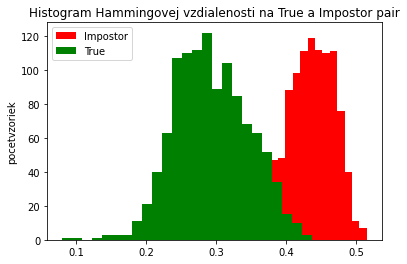

In [115]:
from scipy.spatial import distance


trueidentityHamming = []
falseidentityHamming = []
for pair in truepair:
  prvy = getgaborbinary.get(pair[0]).astype(int)#.flatten()
  druhy = getgaborbinary.get(pair[1]).astype(int)#.flatten()
  
  best = []
  for i in range(0,80):
    prvypom=np.roll(prvy,-40+i,axis=1)
    prvamaska=np.roll(maskforHamm.get(pair[0]), -40+i, axis=1)

    prvypom = cv2.bitwise_and(prvamaska,prvypom) 
    druhypom = cv2.bitwise_and(prvamaska,druhy)
    prvypom = cv2.bitwise_and(maskforHamm.get(pair[1]),prvypom).flatten()
    druhypom = cv2.bitwise_and(maskforHamm.get(pair[1]),druhypom).flatten()

    vzdialenost = distance.hamming(prvypom,druhypom)
    best.append(vzdialenost)
  trueidentityHamming.append(min(best))
  print(min(best))

for pair in impostor:
  prvy = getgaborbinary.get(pair[0]).astype(int)
  druhy = getgaborbinary.get(pair[1]).astype(int)
  best = []
  for i in range(0,80):
    prvypom=np.roll(prvy,-40+i,axis=1)
    prvamaska=np.roll(maskforHamm.get(pair[0]), -40+i, axis=1)

    prvypom = cv2.bitwise_and(prvamaska,prvypom) 
    druhypom = cv2.bitwise_and(prvamaska,druhy)
    prvypom = cv2.bitwise_and(maskforHamm.get(pair[1]),prvypom).flatten()
    druhypom = cv2.bitwise_and(maskforHamm.get(pair[1]),druhypom).flatten()

    vzdialenost = distance.hamming(prvypom,druhypom)
    best.append(vzdialenost)
  falseidentityHamming.append(max(best))
plt.hist(falseidentityHamming, bins='auto', color='r', label='Impostor')
plt.hist(trueidentityHamming, bins='auto', color='g', label='True')
plt.gca().set(title='Histogram Hammingovej vzdialenosti na True a Impostor pair', ylabel='pocetvzoriek')
plt.legend();

plt.show()

In [0]:
print(np.mean(falseidentityHamming),np.mean(trueidentityHamming))

0.39471555330410907 0.25658970066312164


CUSTOM GABOR BINARY

In [0]:
import pickle
with open('/content/drive/My Drive/Colab Notebooks/customgaborbinary.pickle', 'rb') as file:
  customgaborbinary = pickle.load( file)

In [129]:
def findTrue(identity,numofphoto,dicttofind):
  rand = []
  for name in dicttofind.keys():
    if name.split("R")[0].replace("S1",'') == identity and   numofphoto != name.split("R")[1]:
      rand.append(name)
  if not rand:
    return None
  else:
    return random.choice(rand)   
       
def findImpostor(identity,numofphoto,dicttofind):
  rand = []
  for name in dicttofind.keys():
    if name.split("R")[0].replace("S1",'') != identity:
      rand.append(name)
  return random.choice(rand)      


truepair = []
impostor = []
for name in customgaborbinary.keys():
  identity = name.split("R")[0].replace("S1",'')
  numofphoto = name.split("R")[1]
  truematch= findTrue(identity,numofphoto,customgaborbinary)
  impostormatch = findImpostor(identity,numofphoto,customgaborbinary)
  if truematch is None:
    continue
  truepair.append((name,truematch))
  impostor.append((name,impostormatch))

print(truepair)
print(impostor)

[('S1001R01.jpg', 'S1001R03.jpg'), ('S1001R02.jpg', 'S1001R09.jpg'), ('S1001R03.jpg', 'S1001R09.jpg'), ('S1001R04.jpg', 'S1001R07.jpg'), ('S1001R05.jpg', 'S1001R08.jpg'), ('S1001R06.jpg', 'S1001R07.jpg'), ('S1001R07.jpg', 'S1001R09.jpg'), ('S1001R08.jpg', 'S1001R06.jpg'), ('S1001R09.jpg', 'S1001R06.jpg'), ('S1001R10.jpg', 'S1001R08.jpg'), ('S1002R01.jpg', 'S1002R07.jpg'), ('S1002R03.jpg', 'S1002R01.jpg'), ('S1002R04.jpg', 'S1002R01.jpg'), ('S1002R07.jpg', 'S1002R01.jpg'), ('S1004R01.jpg', 'S1004R07.jpg'), ('S1004R02.jpg', 'S1004R03.jpg'), ('S1004R03.jpg', 'S1004R02.jpg'), ('S1004R04.jpg', 'S1004R05.jpg'), ('S1004R05.jpg', 'S1004R07.jpg'), ('S1004R06.jpg', 'S1004R01.jpg'), ('S1004R07.jpg', 'S1004R05.jpg'), ('S1005R02.jpg', 'S1005R07.jpg'), ('S1005R06.jpg', 'S1005R02.jpg'), ('S1005R07.jpg', 'S1005R06.jpg'), ('S1006R04.jpg', 'S1006R07.jpg'), ('S1006R06.jpg', 'S1006R04.jpg'), ('S1006R07.jpg', 'S1006R04.jpg'), ('S1007R01.jpg', 'S1007R06.jpg'), ('S1007R02.jpg', 'S1007R09.jpg'), ('S1007R03.jp

In [0]:
from scipy.spatial import distance


trueidentityHamming = []
falseidentityHamming = []
for pair in truepair:
  prvy = customgaborbinary.get(pair[0]).astype(int)#.flatten()
  druhy = customgaborbinary.get(pair[1]).astype(int)#.flatten()
  
  best = []
  for i in range(0,80):
    prvypom=np.roll(prvy,-40+i,axis=1)
    prvamaska=np.roll(maskforHamm.get(pair[0]), -40+i, axis=1)

    prvypom = cv2.bitwise_and(prvamaska,prvypom) 
    druhypom = cv2.bitwise_and(prvamaska,druhy)
    prvypom = cv2.bitwise_and(maskforHamm.get(pair[1]),prvypom).flatten()
    druhypom = cv2.bitwise_and(maskforHamm.get(pair[1]),druhypom).flatten()

    vzdialenost = distance.hamming(prvypom,druhypom)
    best.append(vzdialenost)
  trueidentityHamming.append(min(best))
  #print(min(best))

for pair in impostor:
  prvy = customgaborbinary.get(pair[0]).astype(int)
  druhy = customgaborbinary.get(pair[1]).astype(int)
  best = []
  for i in range(0,80):
    prvypom=np.roll(prvy,-40+i,axis=1)
    prvamaska=np.roll(maskforHamm.get(pair[0]), -40+i, axis=1)

    prvypom = cv2.bitwise_and(prvamaska,prvypom) 
    druhypom = cv2.bitwise_and(prvamaska,druhy)
    prvypom = cv2.bitwise_and(maskforHamm.get(pair[1]),prvypom).flatten()
    druhypom = cv2.bitwise_and(maskforHamm.get(pair[1]),druhypom).flatten()

    vzdialenost = distance.hamming(prvypom,druhypom)
    best.append(vzdialenost)
  falseidentityHamming.append(max(best))
plt.hist(falseidentityHamming, bins='auto', color='r', label='Impostor')
plt.hist(trueidentityHamming, bins='auto', color='g', label='True')
plt.gca().set(title='Histogram Hammingovej vzdialenosti na True a Impostor pair', ylabel='pocetvzoriek')
plt.legend();

plt.show()

[0.0]
[0.0, 0.01]
[0.0, 0.01, 0.1]
[0.0, 0.01, 0.1, 0.45]
[0.0, 0.01, 0.1, 0.45, 0.83]
[0.0, 0.01, 0.1, 0.45, 0.83, 0.97]
[0.0, 0.01, 0.1, 0.45, 0.83, 0.97, 1.0]
[0.0, 0.01, 0.1, 0.45, 0.83, 0.97, 1.0, 1.0]
[0.0, 0.01, 0.1, 0.45, 0.83, 0.97, 1.0, 1.0, 1.0]
[0.0, 0.01, 0.1, 0.45, 0.83, 0.97, 1.0, 1.0, 1.0, 1.0]
[0.0, 0.01, 0.1, 0.45, 0.83, 0.97, 1.0, 1.0, 1.0, 1.0, 1.0]
[0.0, 0.01, 0.1, 0.45, 0.83, 0.97, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
[0.0, 0.01, 0.1, 0.45, 0.83, 0.97, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
[0.0, 0.01, 0.1, 0.45, 0.83, 0.97, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
[0.0, 0.01, 0.1, 0.45, 0.83, 0.97, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
[0.0, 0.01, 0.1, 0.45, 0.83, 0.97, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
[0.0, 0.01, 0.1, 0.45, 0.83, 0.97, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
[0.0, 0.01, 0.1, 0.45, 0.83, 0.97, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
[0.0, 0.01, 0.1, 0.45, 0.83, 0.97, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0

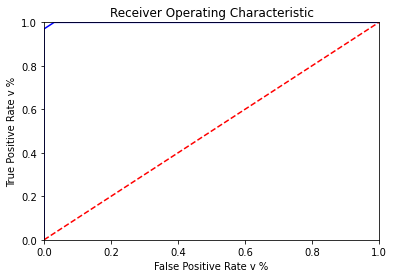

In [126]:
thresh = [0.05,0.1,0.15,0.2,0.25,0.3,0.35,0.4,0.45,0.5,0.55,0.6,0.65,0.7,0.75,0.8,0.85,0.9,0.95]
#thresh = [0.3,0.4,0.5]

FPR=[]
TPR=[]

for t in thresh:
  TP=0
  FP=0
  for distance in trueidentityHamming:
    if(distance<=t):
      TP=TP+1

  for distance in falseidentityHamming:
    if(distance<=t):
      FP=FP+1
    
  TPR.append(round(TP/len(trueidentityHamming),2))
  FPR.append(round(FP/len(falseidentityHamming),2))
  print(TPR)
  
plt.title('Receiver Operating Characteristic')
plt.plot(FPR,TPR, 'b')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0,1])
plt.ylim([0,1])
plt.ylabel('True Positive Rate v %')
plt.xlabel('False Positive Rate v %')
plt.show()

## **GETGABORBINARY DATASET TRAINIG**

In [0]:
from sklearn import svm
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
random_state = np.random.RandomState(0)
from sklearn.metrics import roc_curve, auc
import pylab as pl
from sklearn.metrics import classification_report,accuracy_score

svctrueidentity = []
svcfalseidentity = []
for pair in truepair:
  prvy = getgaborbinary.get(pair[0])
  druhy = getgaborbinary.get(pair[1])
  new_data = np.concatenate((prvy,druhy), axis=0)
  svctrueidentity.append(new_data.flatten())

for pair in impostor:
  prvy = getgaborbinary.get(pair[0])
  druhy = getgaborbinary.get(pair[1])
  new_data = np.concatenate((prvy,druhy), axis=0)
  svcfalseidentity.append(new_data.flatten())

random_state = np.random.RandomState(0)

clf = svm.SVC(kernel='rbf', probability=True, verbose=1)
print(svctrueidentity[0].shape,svcfalseidentity[0].shape)
SVC_features = np.vstack((svctrueidentity, svcfalseidentity)).astype(np.float64)
scaler = StandardScaler().fit(SVC_features)
x = scaler.transform(SVC_features)
y = np.hstack((np.ones(len(svctrueidentity)), np.zeros(len(svcfalseidentity))))
x, y = shuffle(x, y, random_state=random_state)


# Training Features...
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2)
probas_ = clf.fit(x_train,y_train).predict_proba(x_test)
y_pred = clf.predict(x_test)

print("Accuracy: "+str(accuracy_score(y_test, y_pred)))
print('\n')
print(classification_report(y_test, y_pred))

In [0]:
# Compute ROC curve and area the curve
fpr, tpr, thresholds = roc_curve(y_test, probas_[:, 1])
roc_auc = auc(fpr, tpr)
print("Area under the ROC curve for Gabor NO.2 : %f" % roc_auc)

# Plot ROC curve
pl.clf()
pl.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc,color='green')
pl.plot([0, 1], [0, 1], 'k--')
pl.xlim([0.0, 1.0])
pl.ylim([0.0, 1.0])
pl.xlabel('FalsePositiveRate',color='red')
pl.ylabel('TruePositiveRate',color='aqua')
pl.title('ROC pre LBP príznaky',color='white')
pl.legend(loc="lower right")
pl.show()

In [0]:
from sklearn import svm
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
random_state = np.random.RandomState(0)
from sklearn.metrics import roc_curve, auc
import pylab as pl
from sklearn.metrics import classification_report,accuracy_score

svctrueidentity2 = []
svcfalseidentity2 = []
for pair in truepair:
  prvy = customgaborbinary.get(pair[0])
  druhy = customgaborbinary.get(pair[1])
  new_data = np.concatenate((prvy,druhy), axis=0)
  svctrueidentity2.append(new_data.flatten())

for pair in impostor:
  prvy = customgaborbinary.get(pair[0])
  druhy = customgaborbinary.get(pair[1])
  new_data = np.concatenate((prvy,druhy), axis=0)
  svcfalseidentity2.append(new_data.flatten())

random_state = np.random.RandomState(0)

clf = svm.SVC(kernel='poly',degree=4 ,probability=True, verbose=1)
print(svctrueidentity[0].shape,svcfalseidentity[0].shape)
SVC_features = np.vstack((svctrueidentity2, svcfalseidentity2)).astype(np.float64)
scaler = StandardScaler().fit(SVC_features)
x = scaler.transform(SVC_features)
y = np.hstack((np.ones(len(svctrueidentity2)), np.zeros(len(svcfalseidentity2))))
x, y = shuffle(x, y, random_state=random_state)


# Training Features...
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2)
probas_ = clf.fit(x_train,y_train).predict_proba(x_test)
y_pred = clf.predict(x_test)

print("Accuracy: "+str(accuracy_score(y_test, y_pred)))
print('\n')
print(classification_report(y_test, y_pred))

(65536,) (65536,)
[LibSVM]Accuracy: 0.5968819599109132


              precision    recall  f1-score   support

         0.0       0.56      0.78      0.65       220
         1.0       0.66      0.42      0.52       229

    accuracy                           0.60       449
   macro avg       0.61      0.60      0.59       449
weighted avg       0.62      0.60      0.58       449



Area under the ROC curve for Gabor NO.2 : 0.555597


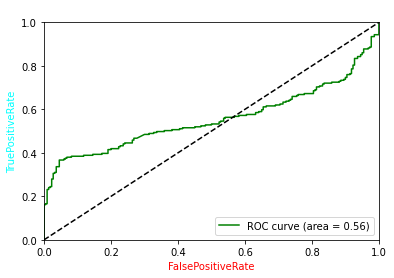

In [0]:
# Compute ROC curve and area the curve
fpr, tpr, thresholds = roc_curve(y_test, probas_[:, 1])
roc_auc = auc(fpr, tpr)
print("Area under the ROC curve for Gabor NO.1 : %f" % roc_auc)

# Plot ROC curve
pl.clf()
pl.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc,color='green')
pl.plot([0, 1], [0, 1], 'k--')
pl.xlim([0.0, 1.0])
pl.ylim([0.0, 1.0])
pl.xlabel('FalsePositiveRate',color='red')
pl.ylabel('TruePositiveRate',color='aqua')
pl.title('ROC krivka',color='white')
pl.legend(loc="lower right")
pl.show()

Spojenie vektorov dvoch obrazkov pre SVM/ANN 